## **Homework 3** *NEUR 3002 / BMED 4803*

**Group 4**: Mani, Mackenzie, Campbell, Vibha, Pooja

#### **Homework 2 Questions**

**1.** 
- This code was generated by ChatGPT using the input: *'write me code to represent and visualize a leaky fire and integrate neuron'*, modified with *'Make it so that I can change current inputs and have firing patterns change, and make it so that it looks like spike trains voltage'*
- The original plot produced with the modified code did not produce accurate spike trains with respect to the threshold levels of the neurons. 
- The code actually works by defining LIF parameters for resistance (**R**), capacitance (**C**), time constant (**tau**), and different voltages representing resting membrane potential, threshold potential, and reset potential.
- Simulation was then carried out by using the equation relating the capactiance to the change in membrane voltage over time to discover the current with respect to time. 
- To calculate spikes, if the overall membrane potential found from integrating dV/dt and seeing if it was >= threshold -- if it was, then a spike would occur and the system would repolarize to reset potential
- The current was calculated as sine wave (further discussed in #4), both voltage and current were plotted using matplotlib.



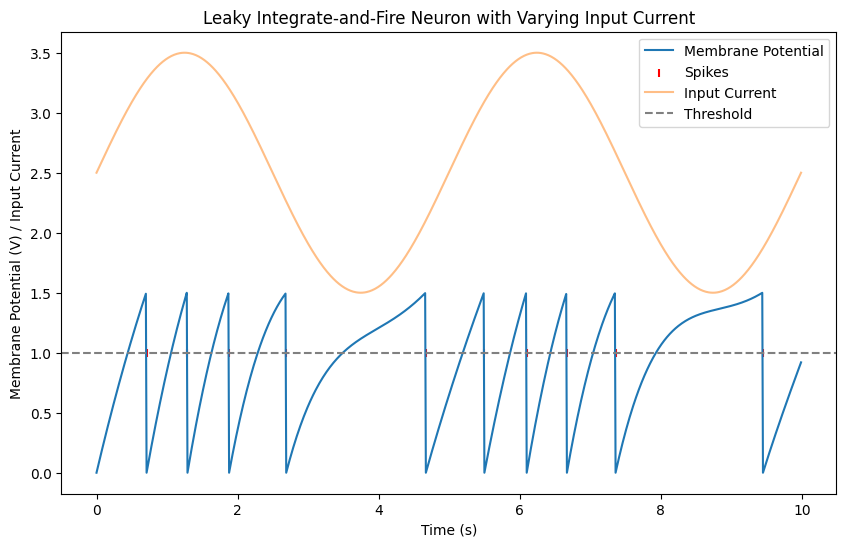

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_leaky_integrate_and_fire(I):
    # Constants
    R = 1.0       # Membrane resistance (in ohms)
    C = 1.0       # Membrane capacitance (in farads)
    tau = R * C   # Time constant (in seconds)
    V_rest = 0.0  # Resting membrane potential (in volts)
    V_thresh = 1.5 # Threshold potential (in volts)
    V_reset = 0.0  # Reset potential (in volts)

    # Simulation parameters
    dt = 0.01      # Time step (in seconds)
    timesteps = 1000
    time = np.arange(0, timesteps * dt, dt)

    # Leaky integrate-and-fire neuron simulation
    V = np.zeros_like(time)
    spikes = []

    for i in range(1, len(time)):
        dV = (V_rest - V[i - 1] + R * I[i-1]) / tau * dt  # Leaky integration with input current
        V[i] = V[i - 1] + dV
        
        if V[i] >= V_thresh:  # Spike condition
            V[i] = V_reset
            spikes.append(i * dt)

    return time, V, spikes

# Varying input current over time
input_current = np.sin(np.linspace(0, 4*np.pi, 1000)) + 2.5

# Simulate leaky integrate-and-fire neuron with varying input
time, membrane_potential, spike_times = simulate_leaky_integrate_and_fire(input_current)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time, membrane_potential, label='Membrane Potential')
plt.scatter(spike_times, np.ones_like(spike_times) * 1.0, color='red', marker='|', label='Spikes')
plt.plot(time, input_current, label='Input Current', alpha=0.5)
plt.axhline(y=1.0, color='gray', linestyle='--', label='Threshold')
plt.title('Leaky Integrate-and-Fire Neuron with Varying Input Current')
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential (V) / Input Current')
plt.legend()
plt.show()


**4.** 
- As seen in the visualization above, this code shows current flow over time as a sine wave. Realistically a biologically accurate neuron's current is dependent on ion channels and integration of graded potentials - this would not be a continous wave but rather a jagged summation of PSPs.
- The membrane potential line trace is not at all representative of neural activity, with no refractory period or undershoot. Also, the rising edge of voltages when spiking, is extremely indicative of an extremely volatile and small time constant 
- The pattern of spiking looks similar to burst firing, given the current input as a sine wave 

**5.**
- The most challenging part of this homework was definitely modifying the visualization to accurately depict the threshold voltage as well as modifying the membrane voltage to depict biologically accurate spike trains.

**6** 
- This homework assignment took around 20-30 minutes.

### **Homework 3 Starts Here**

**1.** 
- Implementing the sodium-gated ion channels will subsequently implement the biological ball-and-chain mechanism that is responsible for the absolute and relative refractory periods. Our previous model did not accurately model a neuron because there was no time interval between consecutive depolarizations. The visualization in the updated model should have flat intervals with no voltage changes along the x-axis between each spike, depicting the refractory period when the neuron is inactivated and there is no cation influx. 

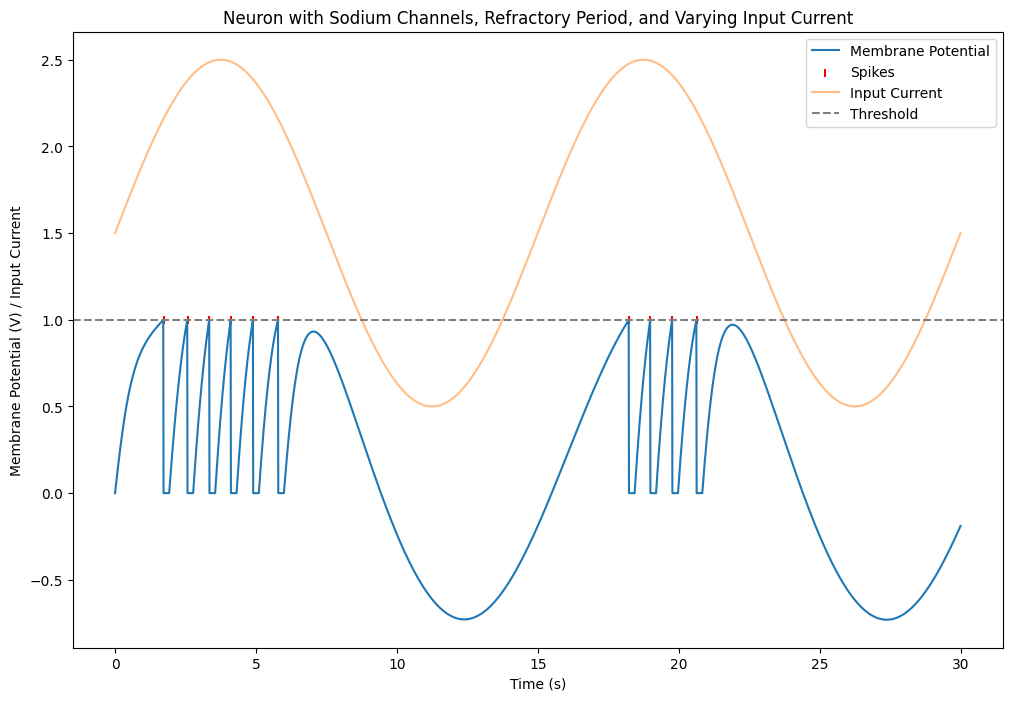

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_neuron_with_sodium_channels_refractory(I, refractory_period=0.2):
    # Constants
    R = 1.0        # Membrane resistance (in ohms)
    C = 1.0        # Membrane capacitance (in farads)
    tau = R * C    # Time constant (in seconds)
    V_rest = 0.0   # Resting membrane potential (in volts)
    V_thresh = 1.0  # Threshold potential (in volts)
    V_reset = 0.0   # Reset potential (in volts)
    g_Na = 10.0     # Sodium conductance (in siemens)
    E_Na = 50.0     # Sodium reversal potential (in volts)

    # Simulation parameters
    dt = 0.01       # Time step (in seconds)
    timesteps = 3000
    time = np.arange(0, timesteps * dt, dt)

    refractory_steps = int(refractory_period / dt)  # Refractory period in time steps

    # Neuron simulation with sodium channels and refractory period
    V = np.zeros_like(time)
    m = np.zeros_like(time)
    h = np.zeros_like(time)
    spikes = []

    refractory_countdown = 0

    for i in range(1, len(time)):
        # If in refractory period, reset potential and skip the rest of the loop
        if refractory_countdown > 0:
            V[i] = V_reset
            refractory_countdown -= 1
            continue

        # Update sodium channel activation and inactivation variables (m and h)
        alpha_m = 0.1 * (V[i - 1] + 40) / (1 - np.exp(-(V[i - 1] + 40) / 10))
        beta_m = 4.0 * np.exp(-(V[i - 1] + 65) / 18)
        alpha_h = 0.07 * np.exp(-(V[i - 1] + 65) / 20)
        beta_h = 1.0 / (1 + np.exp(-(V[i - 1] + 35) / 10))

        m[i] = m[i - 1] + dt * (alpha_m * (1 - m[i - 1]) - beta_m * m[i - 1])
        h[i] = h[i - 1] + dt * (alpha_h * (1 - h[i - 1]) - beta_h * h[i - 1])

        # Sodium current
        I_Na = g_Na * m[i]**3 * h[i] * (V[i - 1] - E_Na)

        # Leaky integration with input current and sodium current
        dV = (V_rest - V[i - 1] + R * (I[i - 1] + I_Na)) / tau * dt
        V[i] = V[i - 1] + dV

        if V[i] >= V_thresh:  # Spike condition
            V[i] = V_reset
            spikes.append(i * dt)
            refractory_countdown = refractory_steps

    return time, V, spikes

# Varying input current over time
input_current = np.sin(np.linspace(0, 4*np.pi, 3000)) + 1.5

# Simulate neuron with sodium channels, refractory period, and varying input
time, membrane_potential, spike_times = simulate_neuron_with_sodium_channels_refractory(input_current)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(time, membrane_potential, label='Membrane Potential')
plt.scatter(spike_times, np.ones_like(spike_times) * 1.0, color='red', marker='|', label='Spikes')
plt.plot(time, input_current, label='Input Current', alpha=0.5)
plt.axhline(y=1.0, color='gray', linestyle='--', label='Threshold')
plt.title('Neuron with Sodium Channels, Refractory Period, and Varying Input Current')
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential (V) / Input Current')
plt.legend()
plt.show()
